In [1]:
import sys
sys.path.extend(['..', '../', '../..', '../../' ])
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from src.const import paths, datasets, networks
from src.parameters import metrics
from src.datasets.extract_part_of_dataset import DatasetPartExtractor
from src.datasets.dataset_generators import DatasetGenerators
from src.keras_callback.time_history import TimeHistory
from src.results.csv_export import export_learning_history_to_csv, export_learning_validation_result_to_csv
from src.results.model_export import clear_exported_models, get_best_model_from_directory
from src.results.result_plot import *
from src.keras_model.lenet5_network import LeNet5Network

Using TensorFlow backend.


# Setup basic params

In [3]:
network_name = networks.lenet5
network = LeNet5Network()
fit_epochs = 50
dataset = datasets.catvsdog
dataset_percentage = 20

network.print_config()

Loss: <function categorical_crossentropy at 0x14d9eab00>
Metrics: ['accuracy', <function precision at 0x14db5ad40>, <function recall at 0x14db5add0>]
Image size: (32, 32)
Grayscale: True
Batch size: 32


# Extract given percentage of source dataset

In [4]:
DatasetPartExtractor().extract(dataset, dataset_percentage)

Checking if dataset exists in /Users/igor/Python/CNN-Architecture-Comparison/data/cat-vs-dog_20/
Dataset cat-vs-dog already exists with 20% rate


# Setup dataset generators for train/test/validate sets

In [5]:
dataset_generators = DatasetGenerators(
    name=f'{dataset}_{dataset_percentage}',
    image_size=network.image_size,
    batch_size=network.batch_size,
    grayscale=network.grayscale
)


Loading train set for cat-vs-dog_20...
Found 3500 images belonging to 2 classes.
Loading test set for cat-vs-dog_20...
Found 1000 images belonging to 2 classes.
Loading validation set for cat-vs-dog_20...
Found 500 images belonging to 2 classes.


# Compile model of network

In [6]:
model = network.get_compiled_model(
    classes=dataset_generators.test.num_classes
)

# Setup fitting callbacks

In [7]:
checkpoint_path = f'{paths.models_location}{network_name}/{dataset}/'
clear_exported_models(checkpoint_path)

best_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}{{epoch:02d}}-{{val_loss}}.h5',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

time_callback = TimeHistory()

model_callbacks = [best_callback, time_callback]

# Perform model fitting

In [8]:
fit_result = model.fit_generator(
    generator=dataset_generators.train,
    epochs=fit_epochs,
    validation_data=dataset_generators.test,
    callbacks = model_callbacks
)

Epoch 1/50
110/110 [==============================] - 8s 74ms/step - loss: 0.6908 - accuracy: 0.5254 - precision: 0.3850 - recall: 0.5634 - val_loss: 0.6873 - val_accuracy: 0.5940 - val_precision: 0.5805 - val_recall: 0.6563

Epoch 00001: val_loss improved from inf to 0.68731, saving model to /Users/igor/Python/CNN-Architecture-Comparison/models/lenet5/cat-vs-dog/01-0.6873096227645874.h5
Epoch 2/50
110/110 [==============================] - 7s 68ms/step - loss: 0.6701 - accuracy: 0.5860 - precision: 0.6005 - recall: 0.5828 - val_loss: 0.8793 - val_accuracy: 0.5860 - val_precision: 0.5509 - val_recall: 0.8964

Epoch 00002: val_loss did not improve from 0.68731
Epoch 3/50
110/110 [==============================] - 7s 68ms/step - loss: 0.6426 - accuracy: 0.6240 - precision: 0.6225 - recall: 0.6828 - val_loss: 0.7186 - val_accuracy: 0.5990 - val_precision: 0.5763 - val_recall: 0.7211

Epoch 00003: val_loss did not improve from 0.68731
Epoch 4/50
110/110 [==============================] - 7

# Retrieve best model found during fitting

In [9]:
best_saved_model_path = get_best_model_from_directory(checkpoint_path)
best_saved_model = keras.models.load_model(best_saved_model_path,
    custom_objects= {
        'precision': metrics.precision,
        'recall': metrics.recall
    }
)

# Evaluate best saved model

In [10]:
validation_result = best_saved_model.evaluate_generator(
    generator=dataset_generators.validate
)

# Results

### Epoch CSV

In [11]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-history.csv'
export_learning_history_to_csv(csv_file_path, fit_result, time_callback.times)

epoch,time,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0,0,0,0,0
1,8.211246013641357,0.6873096227645874,0.593999981880188,0.5805330276489258,0.6562509536743164,0.6907256358691625,0.5254285931587219,0.38495761156082153,0.563419759273529
2,7.4545488357543945,0.8792823553085327,0.5860000252723694,0.5508960485458374,0.8964301943778992,0.6701639595031739,0.5860000252723694,0.6005122065544128,0.5827856063842773
3,7.4767889976501465,0.7186344265937805,0.5989999771118164,0.5763478875160217,0.7210581302642822,0.6423795642852783,0.6240000128746033,0.6225330829620361,0.6827974319458008
4,7.474164009094238,0.5812806487083435,0.6230000257492065,0.6302793622016907,0.6554405093193054,0.6237761395999364,0.6571428775787354,0.6591445803642273,0.6950796842575073
5,7.415236711502075,0.8765814304351807,0.6299999952316284,0.645248293876648,0.562885582447052,0.5953078030858721,0.6828571557998657,0.6828069090843201,0.7022563815116882
6,7.445446968078613,0.5348965525627136,0

### Epoch plots

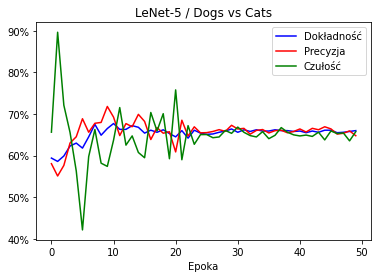

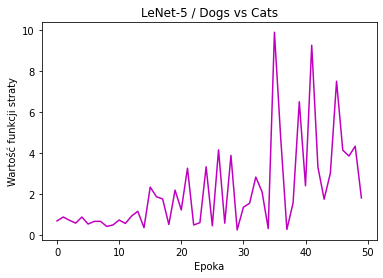

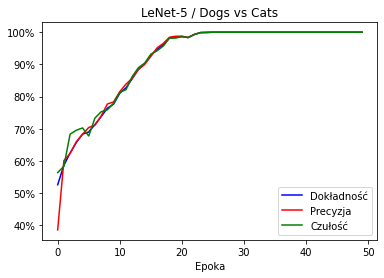

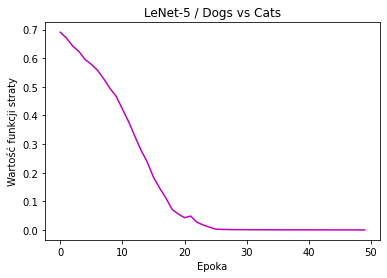

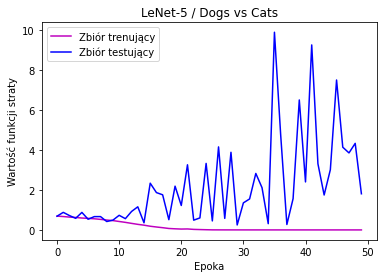

In [12]:
val_metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-metrics.png'
val_loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-loss.png'
metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-metrics.png'
loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-loss.png'
loss_comparison_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-loss-comparison.png'

plot_learning_history_val_metrics(val_metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_val_loss(val_loss_png_file_path, network_name, dataset, fit_result)
plot_learning_history_metrics(metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_loss(loss_png_file_path, network_name, dataset, fit_result)
plot_loss_comparison(loss_comparison_png_file_path, network_name, dataset, fit_result)

### Validation result CSV

In [13]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-result.csv'
export_learning_validation_result_to_csv(csv_file_path, validation_result, time_callback.times)

avg_epoch_time,time,val_loss,val_accuracy,val_precision,val_recall
7.766226167678833,388.31130838394165,3.1309924125671387,0.6840000152587891,0.6626316905021667,0.7196910977363586
